In [1]:
""" TODO
x Grab data from MOABB

Decimation to reduce data points

Initial Noise Filters
- Filter out eye artifacts and head movements (Maxwell and SSS)
- Normalize channel wise

Epoching
- Create -0.1 to 0.9ms stimulus epochs

Label epochs as containing target or not based on moabb data (still having trouble loading data; harder than I thought to work with large datasets)
Demonstrate interperson variability 
- Plot epochs containing target averaged across-epochs with SD
- Plot epochs not containing target average across-epochs with SD Sort based on person

Demonstrate interchannel variability
- Plot channel-wise average for target epochs across epochs 
- ML will be done channel-wise

Classification Pipelines
- Butterworth Bandpass (0.5-20Hz frequencies) + regression on PCA(?)
- adaptive xDawn (spatial filter) + sLDA
- RG (spatial filter) + sLDA

PRESENTATION
- CodeSnap Extension VScode
"""

' TODO\nx Grab data from MOABB\n\nDecimation to reduce data points\n\nInitial Noise Filters\n- Filter out eye artifacts\n- Normalize channel wise\n\nEpoching\n- Create -0.1 to 0.9ms stimulus epochs\n\nLabel epochs as containing target or not based on moabb data (still having trouble loading data; harder than I thought to work with large datasets)\nDemonstrate interperson variability \n- Plot epochs containing target averaged across-epochs with SD\n- Plot epochs not containing target average across-epochs with SD Sort based on person\n\nDemonstrate interchannel variability\n- Plot channel-wise average for target epochs across epochs \n- ML will be done channel-wise\n\nClassification Pipelines\n- Butterworth Bandpass (0.5-20Hz frequencies) + regression on PCA(?)\n- adaptive xDawn (spatial filter) + sLDA\n- RG (spatial filter) + sLDA\n\nPRESENTATION\n- CodeSnap Extension VScode\n'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import moabb.datasets
from moabb.paradigms import P300

from moabb.datasets.compound_dataset import CompoundDataset
import mne

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.


To use the get_shape_from_baseconcar, InputShapeSetterEEG, BraindecodeDatasetLoaderyou need to install `braindecode`.`pip install braindecode` or Please refer to `https://braindecode.org`.


c:\Users\ddbsu\AppData\Local\Programs\Python\Python310\lib\site-packages\moabb\pipelines\__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


In [77]:
fs = 512
full_dataset = moabb.datasets.BI2013a(
    NonAdaptive=True,
    Adaptive=True,
    Training=True,
    Online=True,
)
# paradigm = P300(fmin=0, fmax=30, resample = 128)

In [88]:
subjects_sessions = full_dataset.get_data(subjects=[1])

In [89]:
# 1 sessions: 2 runs (Non-Adaptive vs Adaptive) * 2 phases per run (Training + Online) = 4 mne Raw objects per session
# run order randomized 
# ['FP1', 'FP2', 'F5', 'AFz', 'F6', 'T7', 'Cz', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'Oz', 'O2'] + 1 dimension for events
subjects_sessions[1]['0'] # All 4 runs from Subject 1, Session 1

{'0': <RawArray | 17 x 159232 (311.0 s), ~20.7 MB, data loaded>,
 '1': <RawArray | 17 x 125184 (244.5 s), ~16.3 MB, data loaded>,
 '2': <RawArray | 17 x 139552 (272.6 s), ~18.1 MB, data loaded>,
 '3': <RawArray | 17 x 144384 (282.0 s), ~18.8 MB, data loaded>}

In [6]:
from scipy.signal import decimate

In [95]:
eeg_mne_raw.describe()

<RawArray | 17 x 159232 (311.0 s), ~20.7 MB, data loaded>
ch  name     type  unit        min         Q1     median         Q3        max
 0  Fp1      EEG   µV     28619.28   30337.92   31272.57   32021.51   32603.73
 1  Fp2      EEG   µV     35228.53   37036.60   38952.89   40253.10   40962.55
 2  F5       EEG   µV     21881.29   23732.94   25023.88   25640.42   26507.21
 3  AFz      EEG   µV     25818.69   27472.91   28339.15   29077.39   29811.68
 4  F6       EEG   µV     26899.48   28411.34   29407.17   29927.85   30366.09
 5  T7       EEG   µV     31887.12   33810.55   34817.54   35505.28   36180.83
 6  Cz       EEG   µV     27054.87   28775.14   29825.38   30618.28   31109.32
 7  T8       EEG   µV     27494.59   29289.75   30266.25   31139.62   31730.45
 8  P7       EEG   µV     30458.18   32077.59   32957.64   33539.20   34049.96
 9  P3       EEG   µV     22793.49   24517.90   25646.14   26667.56   27389.31
10  Pz       EEG   µV     29100.43   30478.80   31368.29   31919.62   323

In [99]:
eeg_mne_raw.get_data(picks='eeg')
eeg_mne_raw.get_data(picks='stim')

array([[0., 0., 0., ..., 0., 0., 0.]])

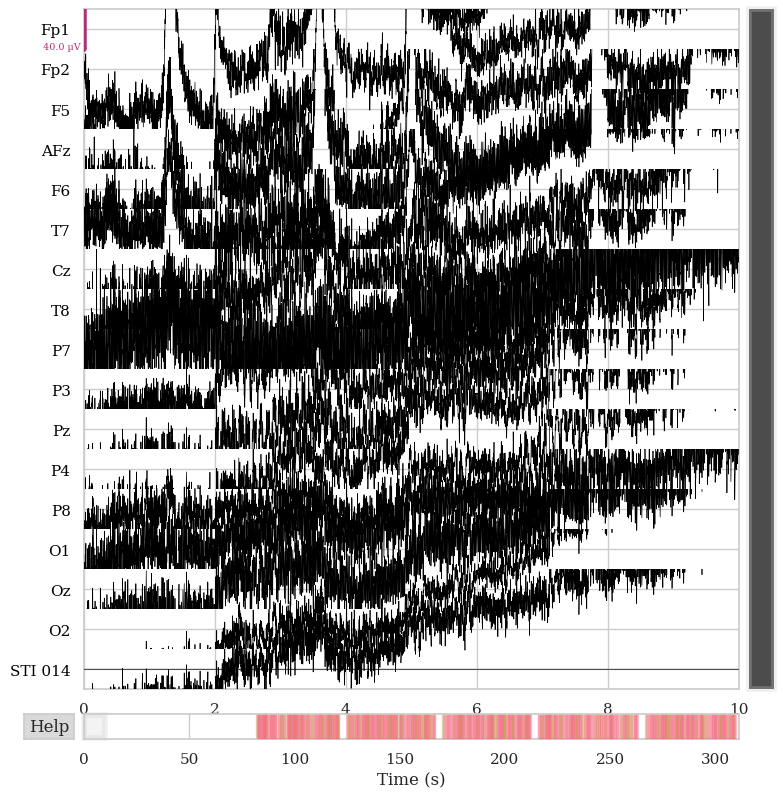

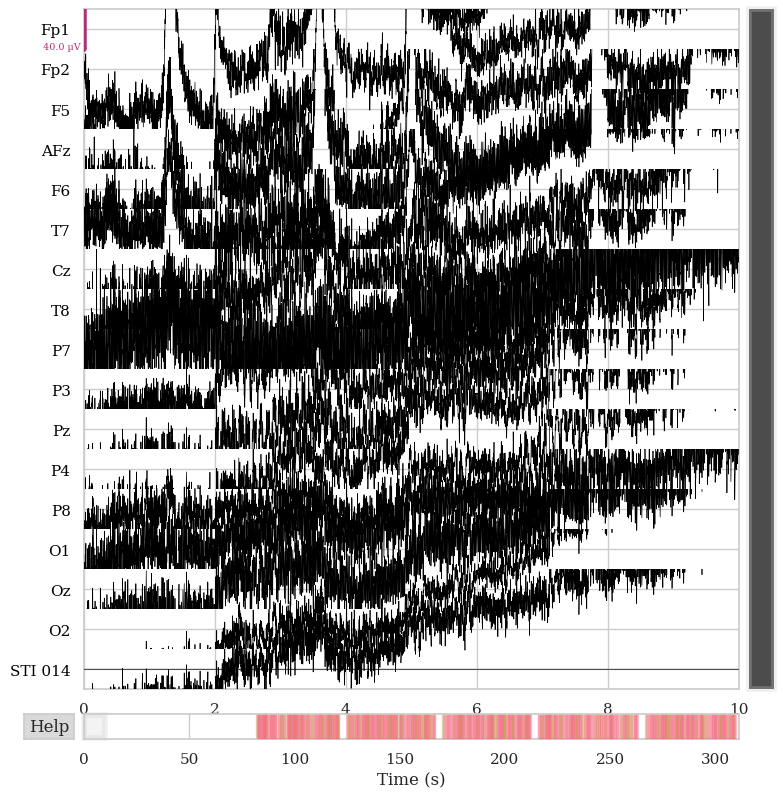

In [104]:
eeg_mne_raw

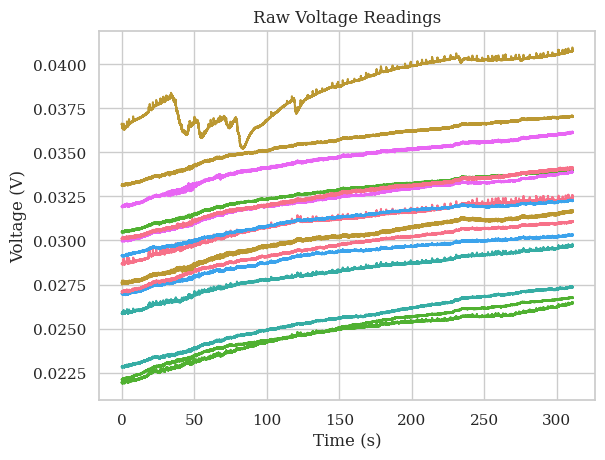

In [100]:
eeg_mne_raw = subjects_sessions[1]['0']['0'] # MNE Raw object for Subject 1, Session 1, Run 1 
# eeg_mne_RAW[:] is a 1x2 tuple ((Data + Events), Time)
all_eeg_channels =  eeg_mne_raw.get_data(picks='eeg') 
all_eeg_channels.shape # (16, 159232)
for i in np.arange(all_eeg_channels.shape[0] - 1):
    plt.plot(eeg_mne_raw.times, all_eeg_channels[i])
    plt.title("Raw Voltage Readings")
    plt.ylabel("Voltage (V)")  
    plt.xlabel("Time (s)")

In [71]:
#eeg_mne_raw.compute_psd().plot_topo()
#eeg_mne_raw.plot_sensors()
eeg_mne_raw

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,19 points
Good channels,16 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,512.00 Hz
Highpass,0.00 Hz
Lowpass,256.00 Hz


Effective window size : 4.000 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


c:\Users\ddbsu\AppData\Local\Programs\Python\Python310\lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


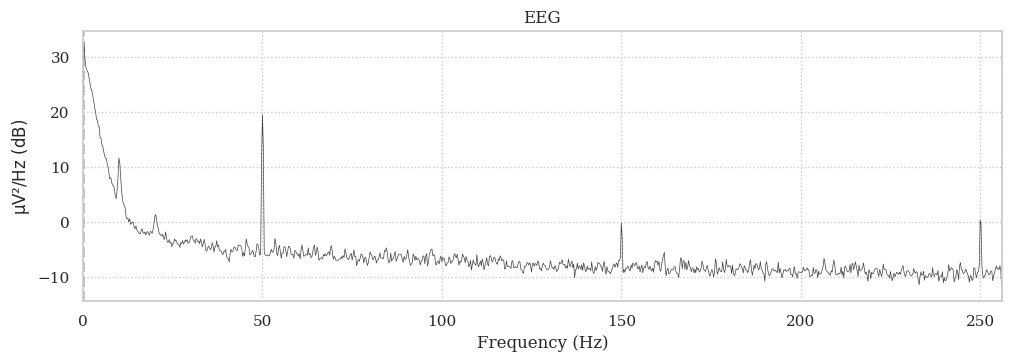

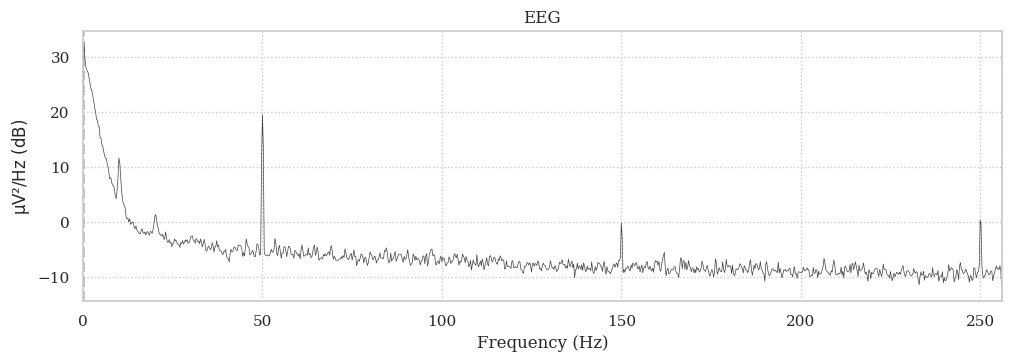

In [9]:
eeg_mne_raw.compute_psd(picks=['Fp1']).plot()

In [10]:
erp.shape[1]
all_eeg_channels.shape

NameError: name 'erp' is not defined

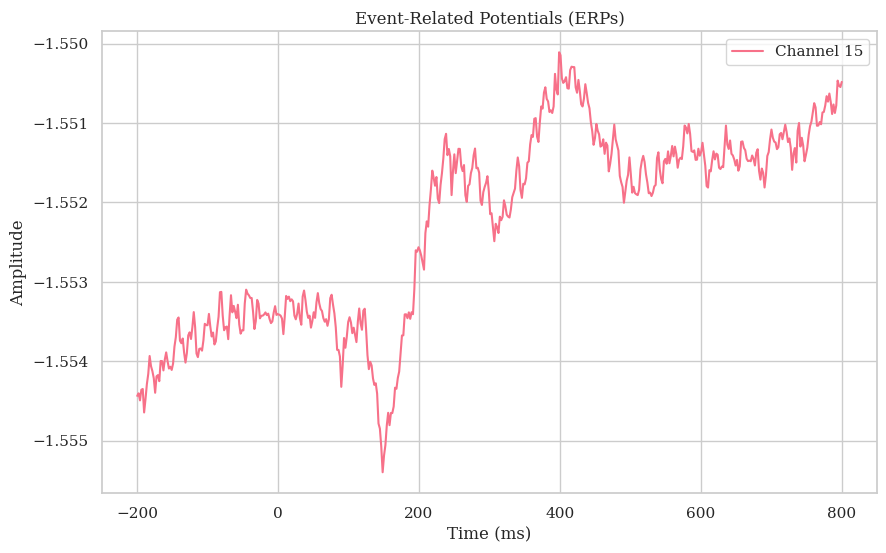

In [17]:
event_indices = np.where(data_and_events[16] == 33285)[0]

# Define the epoch window around each event (adjust as needed)
epoch_start = -200  # milliseconds before the event
epoch_end = 800    # milliseconds after the event

# Convert epoch boundaries to sample indices
start_index = int(epoch_start * 0.001 * fs)  # 512 Hz sampling rate
end_index = int(epoch_end * 0.001 * fs)

# Extract ERP epochs around each event
erp_epochs = [all_eeg_channels[:, i + start_index:(i + end_index + 1)] for i in event_indices]

# Standardize each channel independently
erp_epochs_standardized = [(epoch - np.mean(epoch)) / np.std(epoch) for epoch in erp_epochs]

# Average across epochs to obtain ERP
erp_standardized = np.mean(erp_epochs_standardized, axis=0)

time_points = np.linspace(epoch_start,epoch_end, erp_standardized.shape[1])
# Plot the ERP waveforms
plt.figure(figsize=(10, 6))
# plt.plot(time_points, erp[14])
#for i in range(erp_standardized.shape[0]):
i = 14
plt.plot(time_points, erp_standardized[i], label=f'Channel {i + 1}')

plt.title('Event-Related Potentials (ERPs)')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


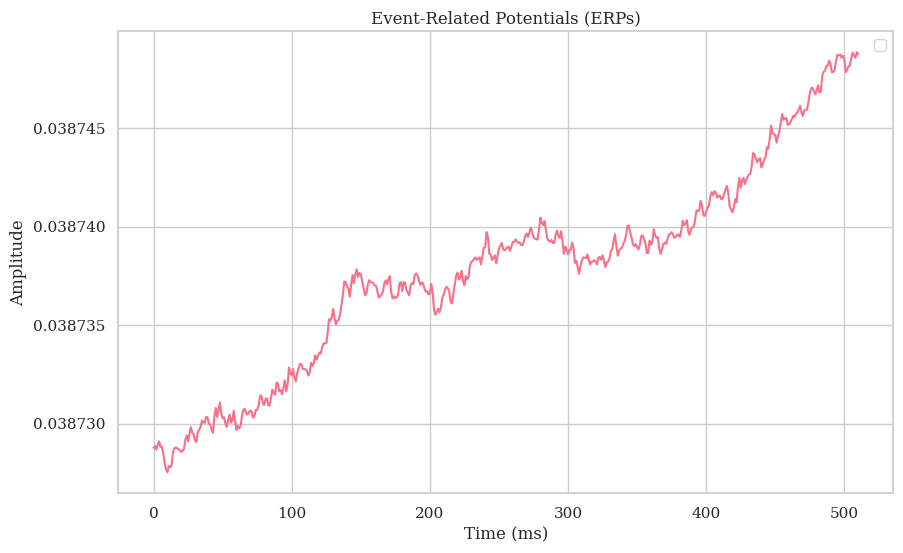

In [ ]:
event_indices = np.where(data_and_events[16] == 33286)[0]

# Define the epoch window around each event (adjust as needed)
epoch_start = -200  # milliseconds before the event
epoch_end = 800    # milliseconds after the event

# Convert epoch boundaries to sample indices
start_index = int(epoch_start * 0.001 * fs)  # 512 Hz sampling rate
end_index = int(epoch_end * 0.001 * fs)

# Extract ERP epochs around each event
erp_epochs = [all_eeg_channels[:, i + start_index:i + end_index] for i in event_indices]

# Average across epochs to obtain ERP
erp = np.mean(erp_epochs, axis=0)

# Plot the ERP waveforms
plt.figure(figsize=(10, 6))
#for i in range(erp.shape[0]):
plt.plot(erp[1])
# plt.plot(np.linspace(epoch_start, epoch_end, erp.shape[1]), erp[i], label=f'Channel {i+1}')

plt.title('Event-Related Potentials (ERPs)')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [ ]:
data_and_events[16].shape

(159232,)

In [ ]:
data_and_events[16].shape

(159232,)

In [ ]:
# plt.plot(testfull1[1]['2']['3'][:][0][16]) the last time point is where there is an ERP?
np.where(subjects_sessions[1]['0']['0'][:][0][16] > 0)[0] / 512

array([ 81.53125   ,  82.11328125,  82.31835938,  82.54882812,
        82.88085938,  83.1796875 ,  83.69921875,  83.98046875,
        84.43164062,  84.61523438,  84.8359375 ,  85.04882812,
        85.34765625,  85.54882812,  85.76367188,  86.09765625,
        86.49804688,  87.39648438,  87.90039062,  88.36328125,
        88.61914062,  88.87890625,  89.23242188,  89.8359375 ,
        90.16992188,  90.4140625 ,  91.23046875,  92.03125   ,
        92.6484375 ,  92.94921875,  93.51367188,  94.21289062,
        94.63085938,  95.61328125,  96.36328125,  96.53125   ,
        96.71289062,  97.        ,  97.18164062,  97.59765625,
        97.86328125,  98.09960938,  98.61328125,  98.84765625,
        99.1328125 ,  99.3984375 ,  99.63671875,  99.9453125 ,
       100.26367188, 100.61523438, 100.88085938, 101.3203125 ,
       101.52929688, 102.15039062, 102.6640625 , 102.91601562,
       103.13085938, 103.3125    , 103.484375  , 104.3359375 ,
       105.1328125 , 105.37890625, 106.13085938, 106.41

In [ ]:

X, y, metadata = paradigm.get_data(full_dataset, subjects=[1])

In [ ]:
from mne.decoding import Vectorizer
from pyriemann.estimation import Xdawn, XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline

from moabb.evaluations import WithinSessionEvaluation

In [ ]:

# metadata  # 10896 epochs, 8 recording sessions, 2 runs of 2 phases
# X.shape # 10896 epochs, 16 channels, 513 time points (512Hz x 1s trial) 
'''
(wet Silver/Silver Chloride electrodes positioned at 
FP1, FP2, F5, AFz, F6, T7, Cz, T8, P7, P3, Pz, P4, P8, O1, Oz, O2 
according to the 10/20 international system.)
'''
# y.shape # 10896 labels for each epoch
from sklearn.preprocessing import FunctionTransformer

In [ ]:
pipelines = {}
labels_dict = {"Target": 1, "NonTarget": 0}

pipelines["RG+LDA"] = make_pipeline(
    FunctionTransformer(decimate, kw_args={'q': 10}),
    XdawnCovariances(
        nfilter=2, classes=[labels_dict["Target"]], estimator="lwf", xdawn_estimator="scm"), #supervised spatial filter
    TangentSpace(), 
    LDA(solver="lsqr", shrinkage="auto"),
)

# pipelines["Xdawn+LDA"] = make_pipeline(
#     Xdawn(nfilter=2, estimator="scm"), 
#     Vectorizer(), 
#     LDA(solver="lsqr", shrinkage="auto")
# )


In [ ]:
evaluation = WithinSessionEvaluation(
    paradigm=paradigm, datasets=full_dataset, suffix="test"
)
results = evaluation.process(pipelines)

In [ ]:
results

In [ ]:
test_data = test_dataset.get_data()

In [ ]:
for eeg in data_set:
    epochs.extend(epoch for signal in labeled)

In [ ]:
classifier_pipelines = {
    'PCA': (make_pipeline()),
    'xDawn + sLDA': (make_pipeline(Xdawn(),LDA(shrinkage='auto',solver='eigen'))),
    'RG + sLDA': (make_pipeline(TangentSpace(metric='riemann'),LDA(shrinkage='auto', solver='eigen')))
}